# Note

There is a typo in the dataset as the column for away team's red cards is called 'AwayTeamReadCards'

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from google.colab import drive
from datetime import datetime

# Utilties

In [ ]:
def standardise_dates(date_str):
    try:
        return datetime.strptime(date_str, "%d/%m/%Y").strftime("%d/%m/%Y")
    except ValueError:
        try:
            return datetime.strptime(date_str, "%d/%m/%y").strftime("%d/%m/%Y")
        except ValueError:
            print(date_str)
            return date_str

def evaluate_model_performance(model_name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    print(f'Results for {model_name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}\n')
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

def plot_actual_vs_predicted(results_df, pipelines):
    fig, axes = plt.subplots(len(pipelines), 1, figsize=(10, 6 * len(pipelines)), sharex=True)
    if len(pipelines) == 1:
        axes = [axes]  # Ensure axes is a list for single subplot case
    for i, (model_name, _) in enumerate(pipelines.items()):
        actual_counts = results_df[f'Actual_{model_name}'].value_counts().sort_index()
        predicted_counts = results_df[f'Predicted_{model_name}'].value_counts().sort_index()

        bar_width = 0.35
        index = range(len(actual_counts))

        axes[i].bar(index, actual_counts, bar_width, label='Actual', color='b', alpha=0.5)
        axes[i].bar([p + bar_width for p in index], predicted_counts, bar_width, label='Predicted', color='r', alpha=0.5)

        axes[i].set_title(f'Actual vs Predicted for {model_name}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks([p + bar_width/2 for p in index])
        axes[i].set_xticklabels(actual_counts.index)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model_name, y_true, y_pred, class_names):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Simulate the season using the models
def simulate_season(X, model_pipeline, team_mapping):
    predictions = model_pipeline.predict(X)
    points = {team: 0 for team in team_mapping.values()}
    # Iterate over each match's prediction with its index
    for i, prediction in enumerate(predictions):
        # Get home and away team for match
        home_team = team_mapping[X.iloc[i]['HomeTeam']]
        away_team = team_mapping[X.iloc[i]['AwayTeam']]
        # Update points based on outcome
        if prediction == 'H':
            points[home_team] += 3
        elif prediction == 'A':
            points[away_team] += 3
        else:
            points[home_team] += 1
            points[away_team] += 1
    return points

# Loading and Exploring Data

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Group Project/PremierLeague.csv')
df.rename(columns={'AwayTeamReadCards': 'AwayTeamRedCards'}, inplace=True) # Fixing typo in original dataset

df['Date'] = df['Date'].apply(standardise_dates)

print("Head:")
print(df.head(), "\n")
print("Info:")
print(df.info(), "\n")
print("Describe:")
print(df.describe(), "\n")
print("Missing Values:")
print(df.isnull().sum())
print("Data Types:")
print(df.dtypes)
print("Number of Unique Values:")
print(df.nunique())
print("Duplicate Rows:")
print(df[df.duplicated()])
print("Number of Duplicate Rows:", df.duplicated().sum())
number_of_seasons = 10
recent_seasons = df['Season'].sort_values(ascending=False).unique()[:number_of_seasons]

Mounted at /content/drive
Head:
      Season        Date Time     HomeTeam        AwayTeam  \
0  1993-1994  14/08/1993  NaN      Arsenal        Coventry   
1  1993-1994  14/08/1993  NaN  Aston Villa             QPR   
2  1993-1994  14/08/1993  NaN      Chelsea       Blackburn   
3  1993-1994  14/08/1993  NaN    Liverpool  Sheffield Weds   
4  1993-1994  14/08/1993  NaN     Man City           Leeds   

   FullTimeHomeTeamGoals  FullTimeAwayTeamGoals FullTimeResult  \
0                      0                      3              A   
1                      4                      1              H   
2                      1                      2              A   
3                      2                      0              H   
4                      1                      1              D   

   HalfTimeHomeTeamGoals  HalfTimeAwayTeamGoals  ... MarketMaxHomeTeam  \
0                    NaN                    NaN  ...               NaN   
1                    NaN                    NaN  .

## Observing varying performance over time

This graph shows the average number of goals by each team that has performed in the premier league over time. By observing these results we can clearly infer that the performance of a team can vary significantly over time.

Chelsea for example has a significant spike in the middle but has somewhat of an arching shape overall. Additionally, Man City, while experiencing their own peaks and valleys over time, are clearly performing significantly better now than at the beginning of their performance history.

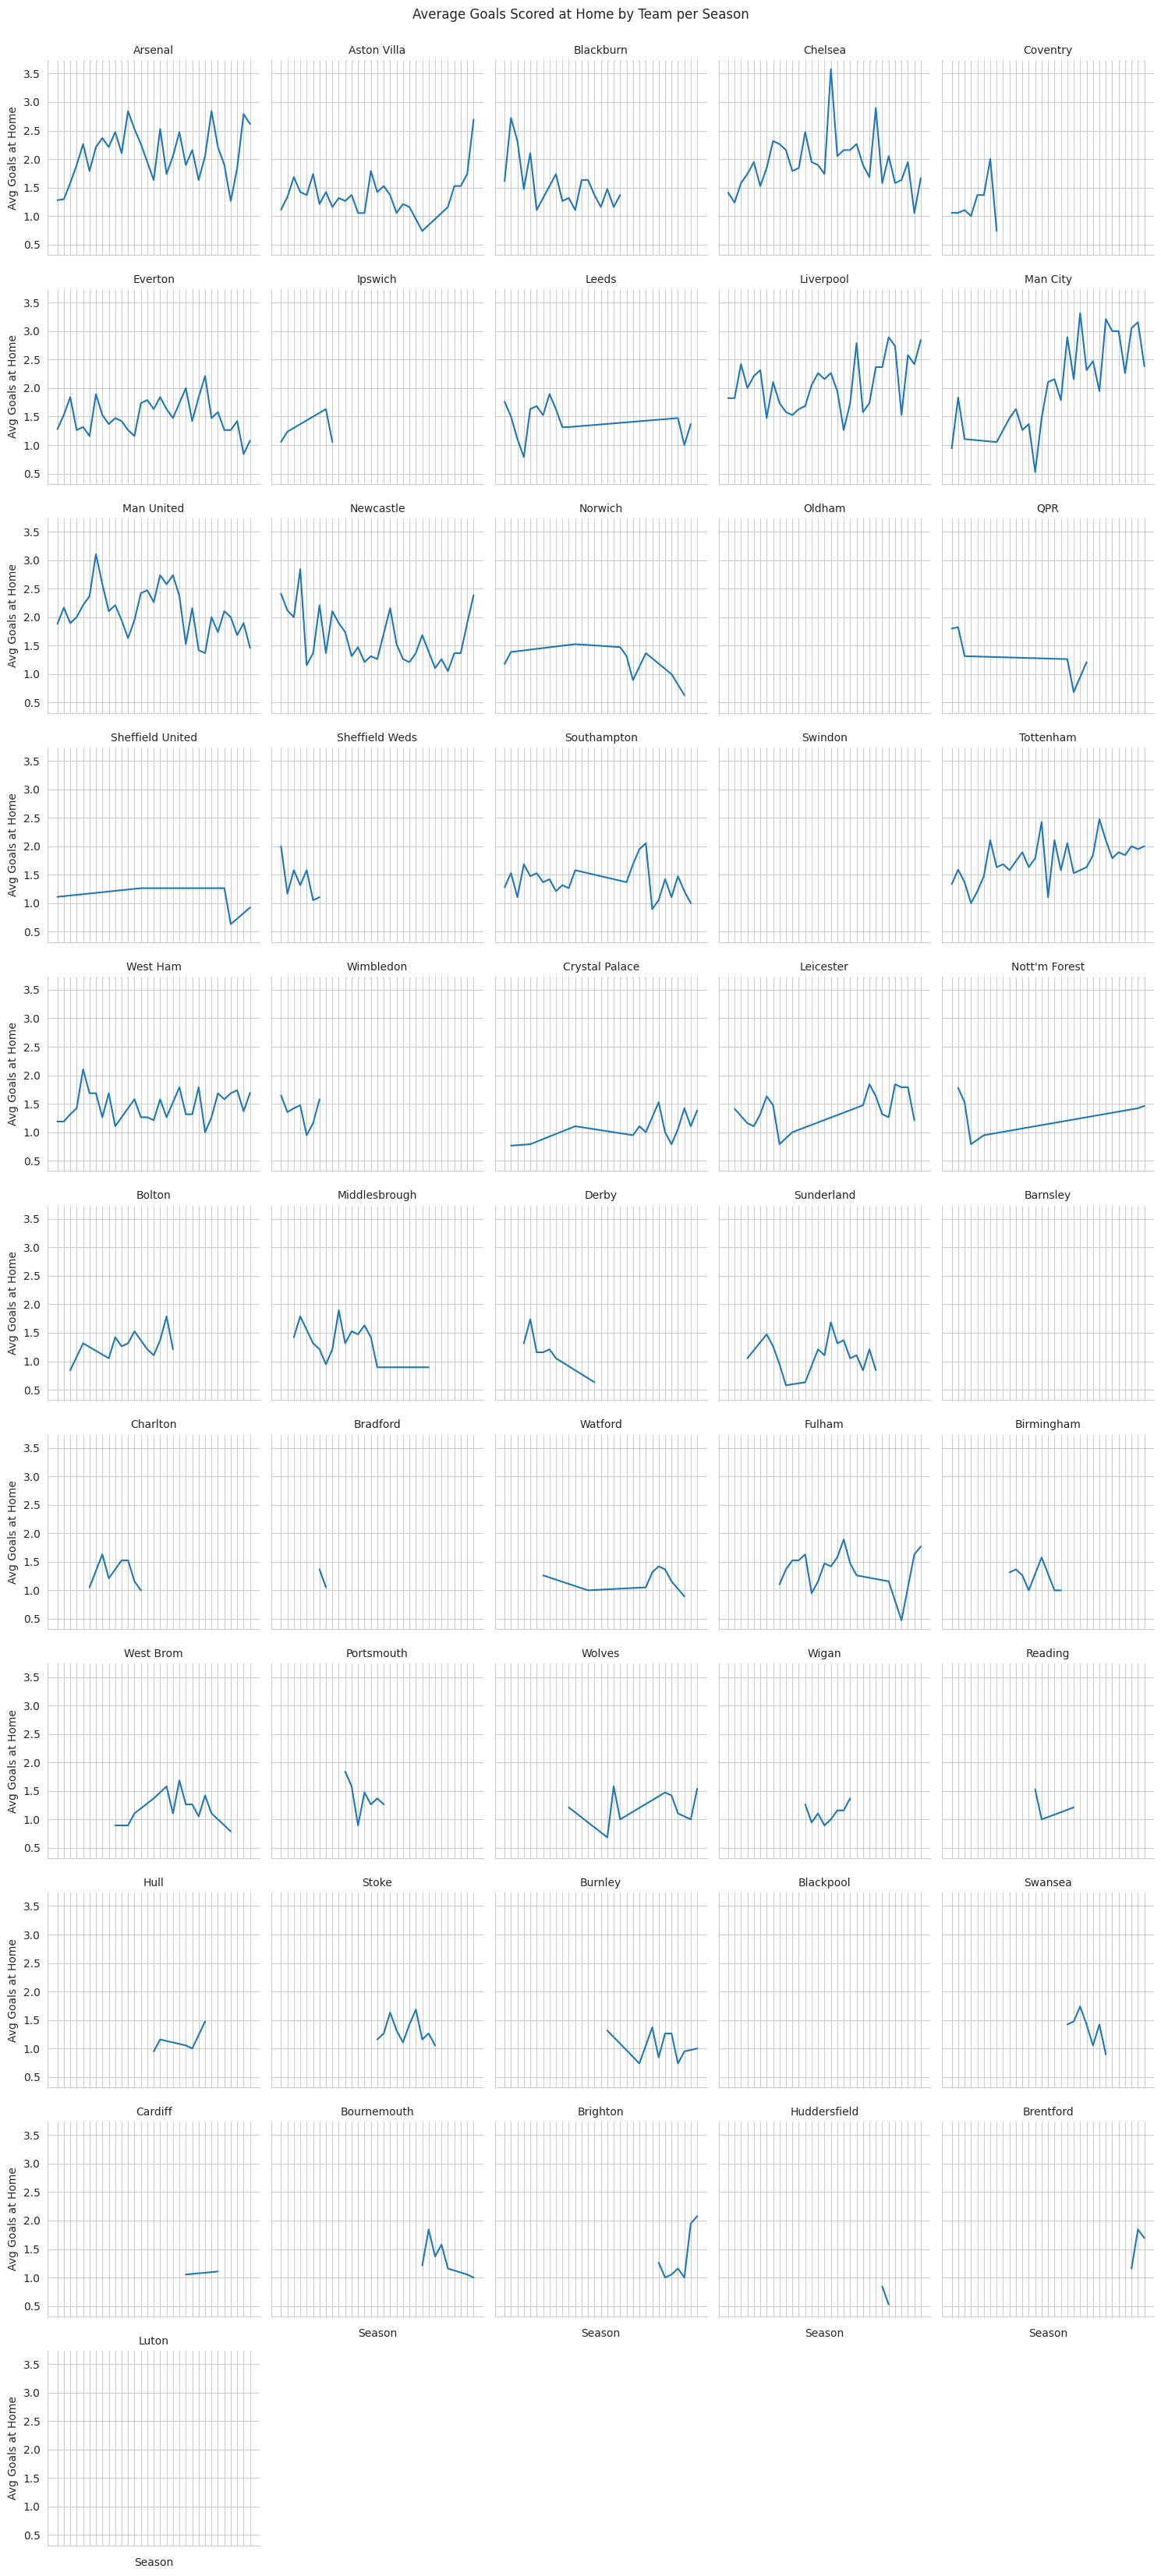

In [29]:
# Calculate average goals scored at home per team per season
average_goals = df.groupby(['Season', 'HomeTeam']).agg({'FullTimeHomeTeamGoals': 'mean'}).reset_index()
average_goals.rename(columns={'FullTimeHomeTeamGoals': 'AverageHomeGoals'}, inplace=True)

# Facet grid to visualise each team's average home goals per season
g = sns.FacetGrid(average_goals, col="HomeTeam", col_wrap=5, height=3, aspect=1)
g.map_dataframe(sns.lineplot, x="Season", y="AverageHomeGoals")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)
g.set_axis_labels("Season", "Avg Goals at Home")
g.fig.suptitle("Average Goals Scored at Home by Team per Season", y=1)
plt.tight_layout()
plt.show()

# Exploratory Data Analysis

In this section we use Exploratory Data Analysis to gain insights into the data available in the recent seasons we have selected from the premier league dataset.


## Initial Inspection

Limiting our dataset to the last 10 seasons (Starting from the 2014-2015 season) we can see that we have access to information about 3,678 matches.

The betting data (Which includes the time feature) is incomplete as some features only started being recorded during the 2002-2003 season. Other aspects of the betting data were only made available even more recently during the 2019-2020 season.

In [ ]:
df_recent_seasons = df[df['Season'].isin(recent_seasons)].copy()
print("Head:")
print(df_recent_seasons.head(), "\n")
print("Info:")
print(df_recent_seasons.info(), "\n")
print("Describe:")
print(df_recent_seasons.describe(), "\n")
print("Missing Values:")
print(df_recent_seasons.isnull().sum())
print("Data Types:")
print(df_recent_seasons.dtypes)
print("Number of Unique Values:")
print(df_recent_seasons.nunique())
print("Duplicate Rows:")
print(df_recent_seasons[df_recent_seasons.duplicated()])
print("Number of Duplicate Rows:", df_recent_seasons.duplicated().sum())


Head:
         Season        Date Time    HomeTeam        AwayTeam  \
7980  2014-2015  16/08/2014  NaN     Arsenal  Crystal Palace   
7981  2014-2015  16/08/2014  NaN   Leicester         Everton   
7982  2014-2015  16/08/2014  NaN  Man United         Swansea   
7983  2014-2015  16/08/2014  NaN         QPR            Hull   
7984  2014-2015  16/08/2014  NaN       Stoke     Aston Villa   

      FullTimeHomeTeamGoals  FullTimeAwayTeamGoals FullTimeResult  \
7980                      2                      1              H   
7981                      2                      2              D   
7982                      1                      2              A   
7983                      0                      1              A   
7984                      0                      1              A   

      HalfTimeHomeTeamGoals  HalfTimeAwayTeamGoals  ... MarketMaxHomeTeam  \
7980                    1.0                    1.0  ...               NaN   
7981                    1.0             

## Setting styles for consistency

In [ ]:
# Setting styles for consistency across graphs
sns.set_style("whitegrid")
plot_palette = {"H": "skyblue", "A": "salmon", "D": "grey"}

## Distribution of match outcomes

This histogram displays the frequency of matches with a specific number of goals scored by home and away teams, allowing us to see common scoring patterns.

We can see three notable patterns from the graph:
*   Home Team Advantage: Home wins are consistently the most common outcome across most seasons, highlighting the traditional 'home advantage' where teams are more likely to win when playing on their home ground. This could be due to various factors such as familiarity with the pitch, support from local fans, or less travel fatigue
*   The 2020-2021 season stands out as an anomaly where away wins were more common than home wins. This unusual pattern could be attributed to the unique circumstances of that season, such as the absence of fans in stadiums due to the COVID-19 pandemic, which may have negated some aspects of the home advantage.
*   Draws are consistently the least common outcome across all the seasons depicted. This suggests that, despite the competitive nature of the league, matches are more likely to result in a decisive outcome (win or loss) rather than a draw.


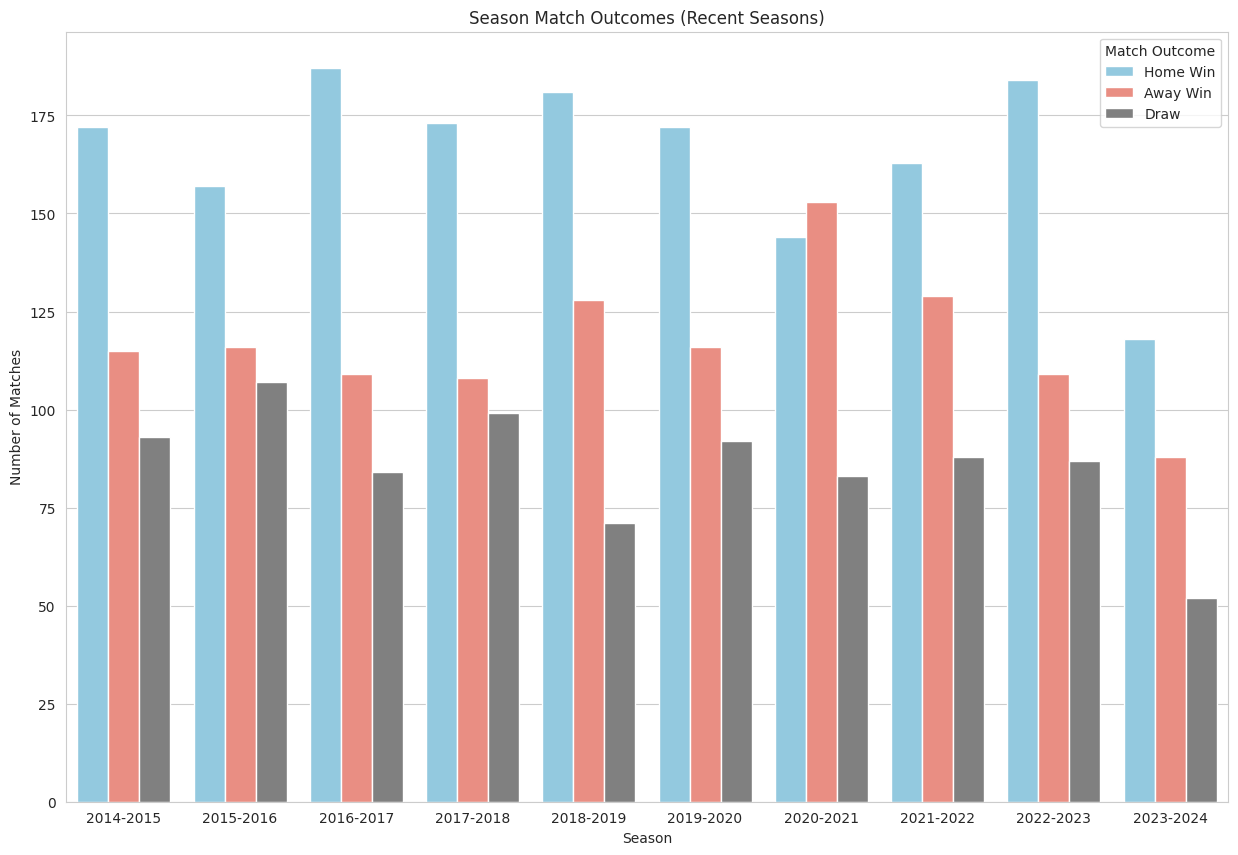

In [ ]:
# Season Match Outcomes
plt.figure(figsize=(15, 10))
sns.countplot(data=df_recent_seasons, x='Season', hue='FullTimeResult', palette=plot_palette, order=recent_seasons[::-1], hue_order=['H', 'A', 'D'])
plt.title('Season Match Outcomes (Recent Seasons)')
plt.xlabel('Season')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome', labels=['Home Win', 'Away Win', 'Draw'])
plt.show()

##  Goal score distribution

*   Scoring Patterns: The distribution of goals scored by home and away teams shows distinct patterns. The peak for home team goals is typically higher than that for away team goals, reinforcing the notion of home advantage in terms of scoring.

*    Common Match Outcomes: The most frequent number of goals scored by home teams is 1 or 2, while away teams most commonly score 0 or 1 goal. This indicates that tight, low-scoring matches are common in the league.

*   High-Scoring Games Are Less Common: As the number of goals increases, the frequency of matches with that many goals scored decreases, showing that high-scoring games are less common. Games with more than 3 goals by one team are relatively rare, suggesting that defensive play may be a significant factor in the league.


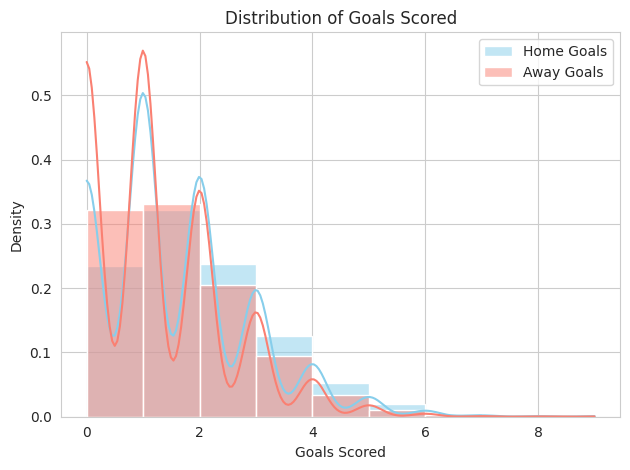

In [ ]:
# Distribution of goals scored
sns.histplot(data=df_recent_seasons, x='FullTimeHomeTeamGoals', color=plot_palette['H'], label='Home Goals', kde=True, stat='density', binwidth=1)
sns.histplot(data=df_recent_seasons, x='FullTimeAwayTeamGoals', color=plot_palette['A'], label='Away Goals', kde=True, stat='density', binwidth=1)
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals Scored')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Heatmap of teams

*   Home Advantage: Certain teams, represented by rows with multiple dark cells, consistently win at home against various opponents. These teams can be considered strong home performers.

*   Key Rivalries and Matchups: The heatmap can highlight how to specific teams perform when playing head-to-head, This can be helpful for understanding team dynamics.

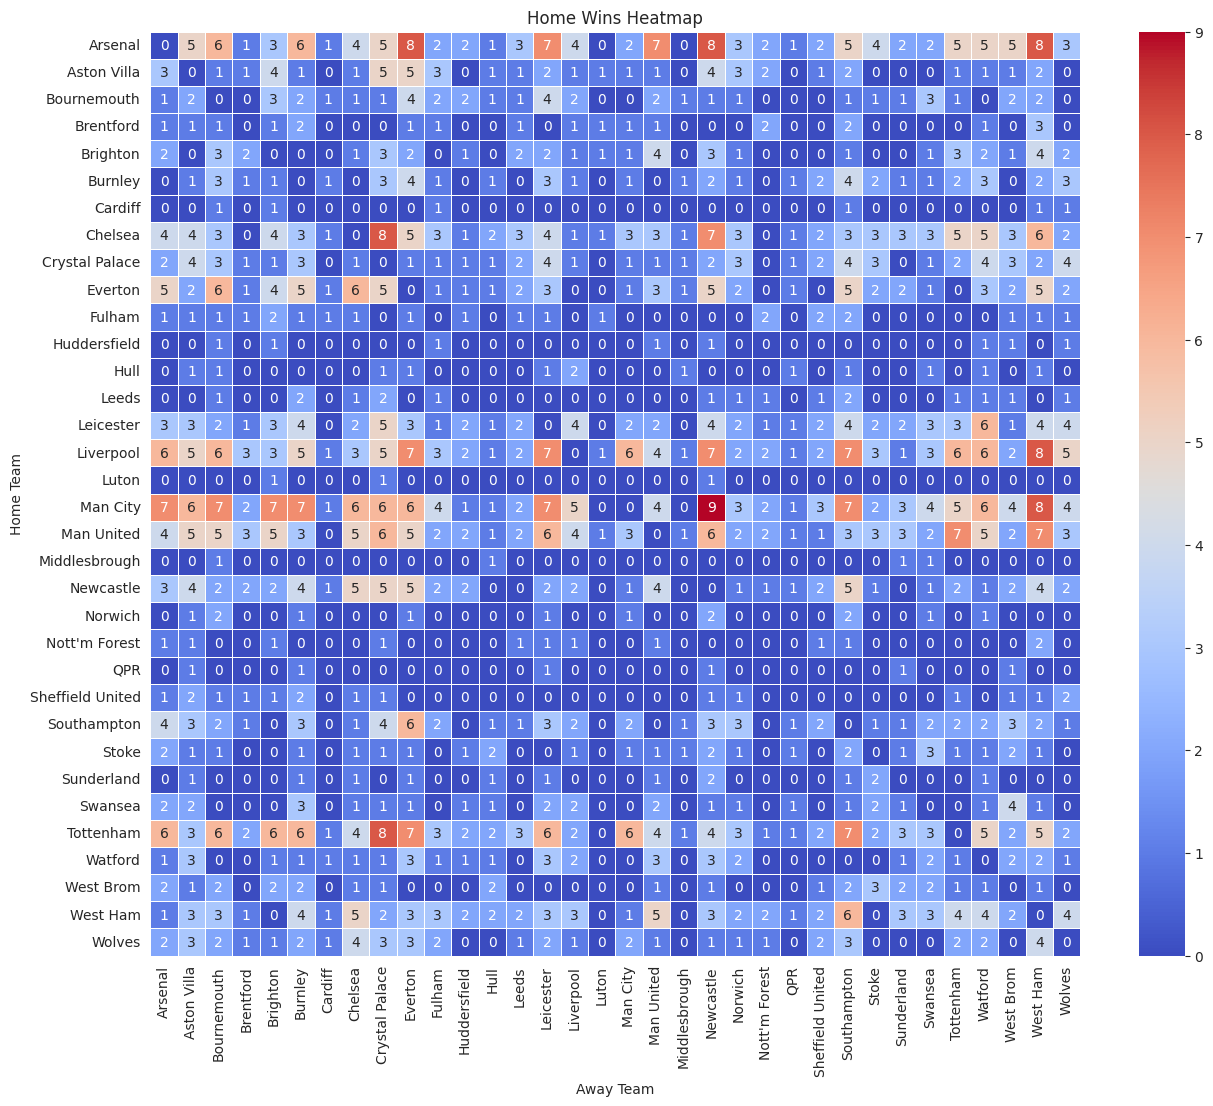

In [13]:
# Create a pivot table with home teams as rows, away teams as columns, and counts of 'FullTimeResult' as values
performance_matrix = df_recent_seasons.pivot_table(index='HomeTeam', columns='AwayTeam', values='FullTimeResult', aggfunc=lambda x: (x=='H').sum())

# Fill NaN values with 0 - assuming no matches between some pairs
performance_matrix = performance_matrix.fillna(0)

# Visualise the data: Create a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(performance_matrix, annot=True, fmt=".0f", cmap='coolwarm', linewidths=.5)
plt.title('Home Wins Heatmap')
plt.xlabel('Away Team')
plt.ylabel('Home Team')
plt.show()

## Fouls and Match Outcome Correlation

*   The box plot comparing the total fouls in a match with the match outcome (home win, away win, draw) does not show a clear, consistent pattern linking the number of fouls with a specific outcome. All three outcome categories have similar median values and interquartile ranges for total fouls.
*   This suggests that the total number of fouls committed in a match might not have a direct or significant influence on the match outcome. Other factors, such as the severity of the fouls, the timing, and how they disrupt play, might be more consequential.

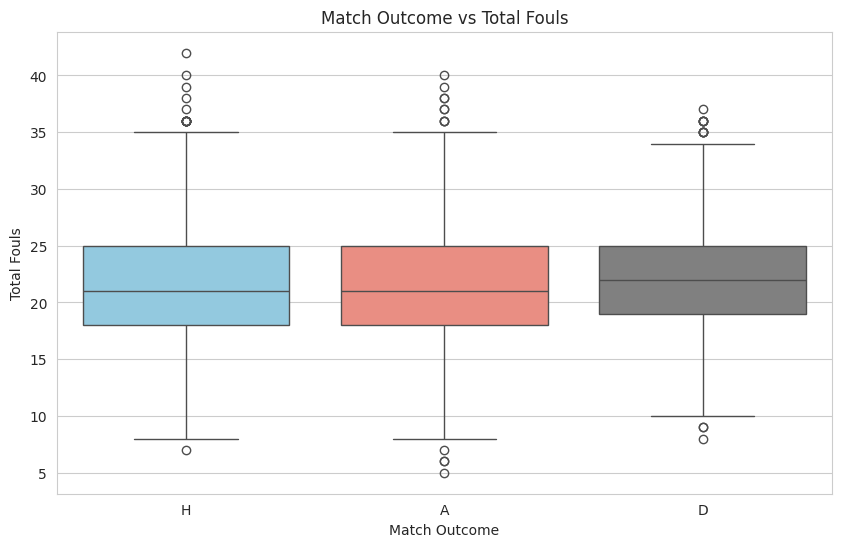

In [14]:
# Calculate total fouls
df_recent_seasons['TotalFouls'] = df_recent_seasons['HomeTeamFouls'] + df_recent_seasons['AwayTeamFouls']

plt.figure(figsize=(10, 6))
sns.boxplot(x='FullTimeResult', y='TotalFouls', data=df_recent_seasons, hue='FullTimeResult', palette=plot_palette, dodge=False, order=['H', 'A', 'D'], legend=False)
plt.title('Match Outcome vs Total Fouls')
plt.xlabel('Match Outcome')
plt.ylabel('Total Fouls')

plt.show()

## Correlation between shot accuracy and match outcome

Home Team Shot Accuracy vs Match Outcome

*   Influence of Accuracy on Outcomes: The boxplot for Home Team Shot Accuracy vs Match Outcome indicates the relationship between a team’s shooting accuracy at home and the final result of the match. We can see that higher median values for accuracy can be seen in matches that the home team won, meaning that there is a strong link between effective goal-scoring opportunities and winning.

Away Team Shot Accuracy vs Match Outcome

*   Correlation with Away Success: For away teams, the boxplot shows that matches where the away team won generally have higher shot accuracy compared to matches that ended in a draw or a home win. This underscores the importance of capitalising on scoring opportunities in away games, where teams have fewer chances to score.

*   Interquartile ranges: We can see a reasonably consistent interquartile range across all of the different outcomes suggesting that the away teams may maintain a higher level of shot accuracy regardless of the match outcome.

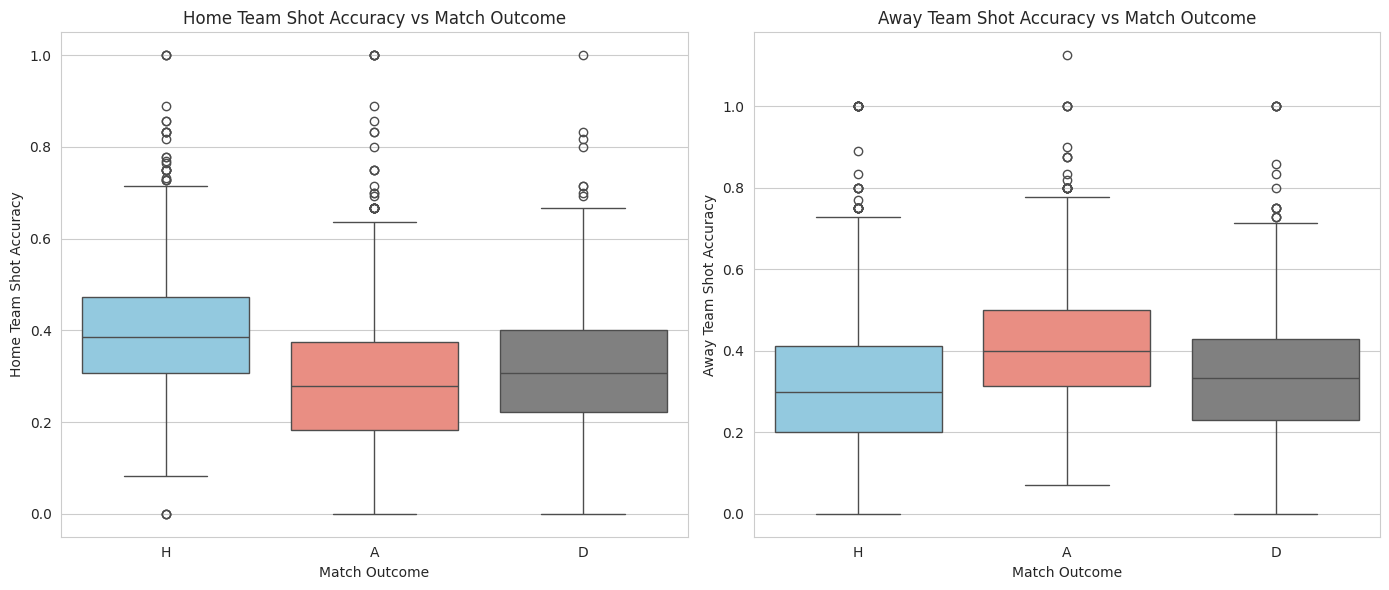

In [15]:
df_recent_seasons['HomeTeamShotAccuracy'] = df_recent_seasons['HomeTeamShotsOnTarget'] / df_recent_seasons['HomeTeamShots']
df_recent_seasons['AwayTeamShotAccuracy'] = df_recent_seasons['AwayTeamShotsOnTarget'] / df_recent_seasons['AwayTeamShots']
df_recent_seasons['HomeTeamShotAccuracy'] = df_recent_seasons['HomeTeamShotAccuracy'].fillna(0)
df_recent_seasons['AwayTeamShotAccuracy'] = df_recent_seasons['AwayTeamShotAccuracy'].fillna(0)
df_plot = df_recent_seasons.dropna(subset=['HomeTeamShotAccuracy', 'AwayTeamShotAccuracy', 'FullTimeResult'])

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Home Team Shot Accuracy vs FullTimeResult
sns.boxplot(x='FullTimeResult', y='HomeTeamShotAccuracy', data=df_plot, hue='FullTimeResult', ax=axes[0], palette=plot_palette, dodge=False, order=['H', 'A', 'D'], legend=False)
axes[0].set_title('Home Team Shot Accuracy vs Match Outcome')
axes[0].set_xlabel('Match Outcome')
axes[0].set_ylabel('Home Team Shot Accuracy')

# Away Team Shot Accuracy vs FullTimeResult
sns.boxplot(x='FullTimeResult', y='AwayTeamShotAccuracy', data=df_plot, hue='FullTimeResult', ax=axes[1], palette=plot_palette, dodge=False, order=['H', 'A', 'D'], legend=False)
axes[1].set_title('Away Team Shot Accuracy vs Match Outcome')
axes[1].set_xlabel('Match Outcome')
axes[1].set_ylabel('Away Team Shot Accuracy')

plt.tight_layout()
plt.show()

## Defensive Strength

Home and Away Team Defensive Strength vs Match Outcome

*   Home team defense: The subplot for Home Team Defensive Strength vs Match Outcome represents the home team’s defensive actions (fouls and cards) and match results. Teams with better defenses are slihgtly more like to win.


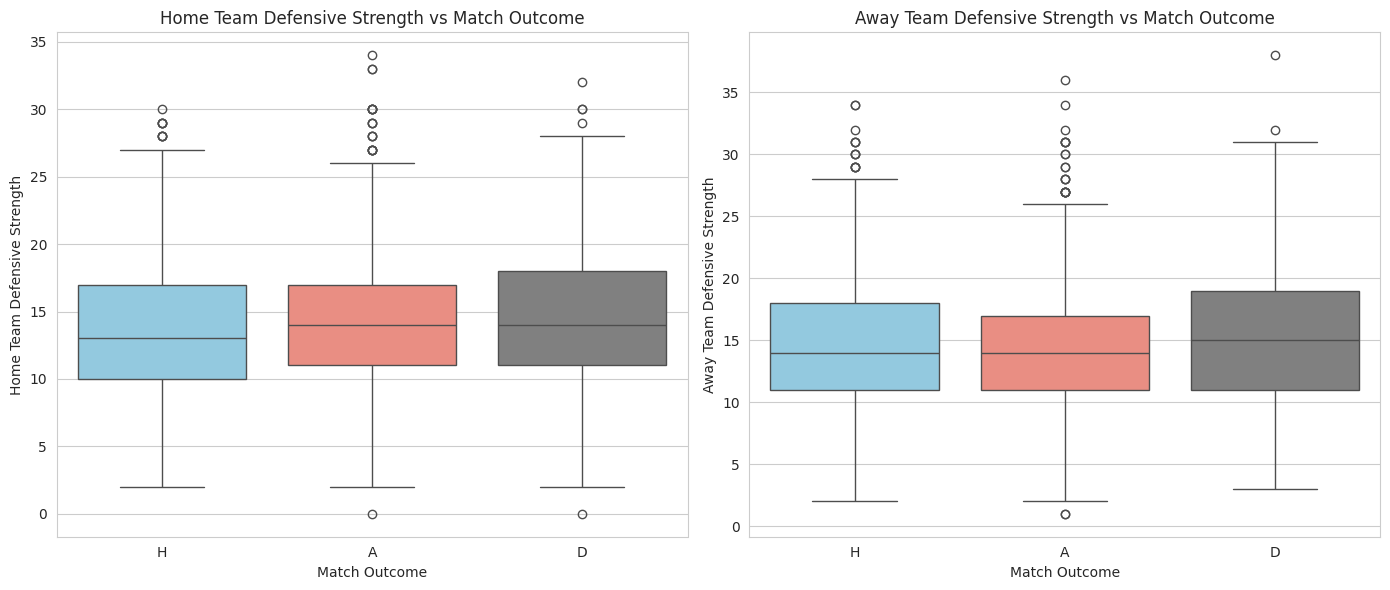

In [16]:
# Calculate Defensive Strength for both Home and Away teams
df_recent_seasons['HomeTeamDefensiveStrength'] = df_recent_seasons['HomeTeamFouls'] + df_recent_seasons['HomeTeamYellowCards'] * 2 + df_recent_seasons['HomeTeamRedCards'] * 3
df_recent_seasons['AwayTeamDefensiveStrength'] = df_recent_seasons['AwayTeamFouls'] + df_recent_seasons['AwayTeamYellowCards'] * 2 + df_recent_seasons['AwayTeamRedCards'] * 3
df_recent_seasons['HomeTeamDefensiveStrength'] = df_recent_seasons['HomeTeamDefensiveStrength'].fillna(0)
df_recent_seasons['AwayTeamDefensiveStrength'] = df_recent_seasons['AwayTeamDefensiveStrength'].fillna(0)

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Home Team Defensive Strength vs FullTimeResult
sns.boxplot(x='FullTimeResult', y='HomeTeamDefensiveStrength', data=df_recent_seasons, hue='FullTimeResult', ax=axes[0], palette=plot_palette, dodge=False, order=['H', 'A', 'D'], legend=False)
axes[0].set_title('Home Team Defensive Strength vs Match Outcome')
axes[0].set_xlabel('Match Outcome')
axes[0].set_ylabel('Home Team Defensive Strength')

# Away Team Defensive Strength vs FullTimeResult
sns.boxplot(x='FullTimeResult', y='AwayTeamDefensiveStrength', data=df_recent_seasons, hue='FullTimeResult', ax=axes[1], palette=plot_palette, dodge=False, order=['H', 'A', 'D'])
axes[1].set_title('Away Team Defensive Strength vs Match Outcome')
axes[1].set_xlabel('Match Outcome')
axes[1].set_ylabel('Away Team Defensive Strength')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [17]:
# Define numerical features
numerical_features = [
    'HomeTeamShots', 'AwayTeamShots', 'HomeTeamShotsOnTarget', 'AwayTeamShotsOnTarget',
    'HomeTeamCorners', 'AwayTeamCorners', 'HomeTeamFouls', 'AwayTeamFouls',
    'HomeTeamYellowCards', 'AwayTeamYellowCards', 'HomeTeamRedCards', 'AwayTeamRedCards',
    'HomeTeamShotAccuracy', 'AwayTeamShotAccuracy', 'HomeTeamDefensiveStrength', 'AwayTeamDefensiveStrength'
]
# Define categorical features
categorical_features = ['HomeTeam', 'AwayTeam']

# Combined features
selected_features = numerical_features + categorical_features

# Filtered dataframe
df_filtered = df_recent_seasons[df_recent_seasons['Season'].isin(recent_seasons)][numerical_features + categorical_features + ['Season', 'FullTimeResult']]

# Splitting the dataset into training and testing sets
train_data = df_filtered[df_filtered['Season'] != '2023-2024']
test_data = df_filtered[df_filtered['Season'] == '2023-2024']

# Separating features and target variable
X_train = train_data[numerical_features + categorical_features]
y_train = train_data['FullTimeResult']
X_test = test_data[numerical_features + categorical_features]
y_test = test_data['FullTimeResult']

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Model Training and Evaluation

In [20]:
# Define and create pipelines for each model
pipelines = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVC(probability=True, random_state=42))
    ])
}

metrics = {}
for model_name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    # Adding the overall accuracy to the report dictionary
    report['accuracy'] = accuracy

    metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
    print(f'Results for {model_name}:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}\n')

Results for Logistic Regression:
Accuracy: 0.5969
Precision: 0.5554
Recall: 0.5969
F1-Score: 0.5707

Results for Random Forest:
Accuracy: 0.6124
Precision: 0.5478
Recall: 0.6124
F1-Score: 0.5697

Results for SVM:
Accuracy: 0.6047
Precision: 0.5319
Recall: 0.6047
F1-Score: 0.5567



# Visualisation of Model Performance and Confusion Matrices

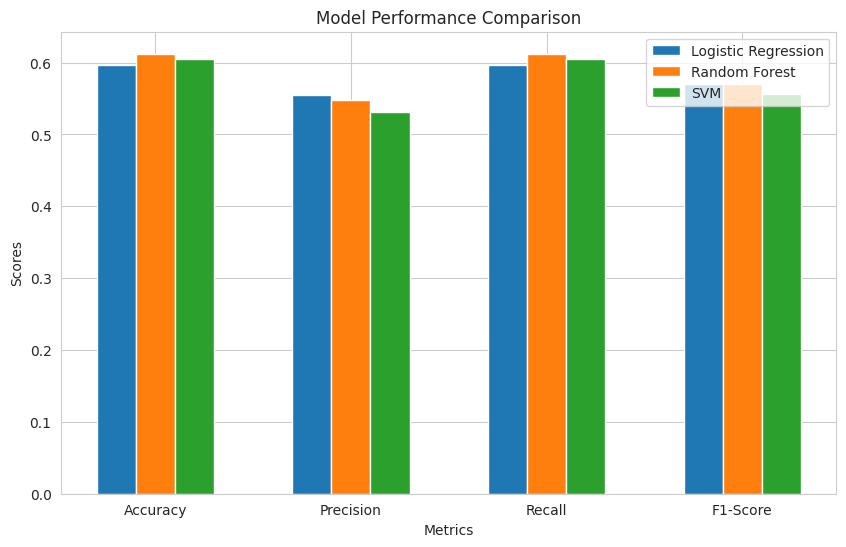

Confusion Matrix for Logistic Regression:
[[57 12 19]
 [19  6 27]
 [18  9 91]]
Confusion Matrix for Random Forest:
[[58  9 21]
 [20  3 29]
 [16  5 97]]
Confusion Matrix for SVM:
[[59  8 21]
 [19  2 31]
 [20  3 95]]


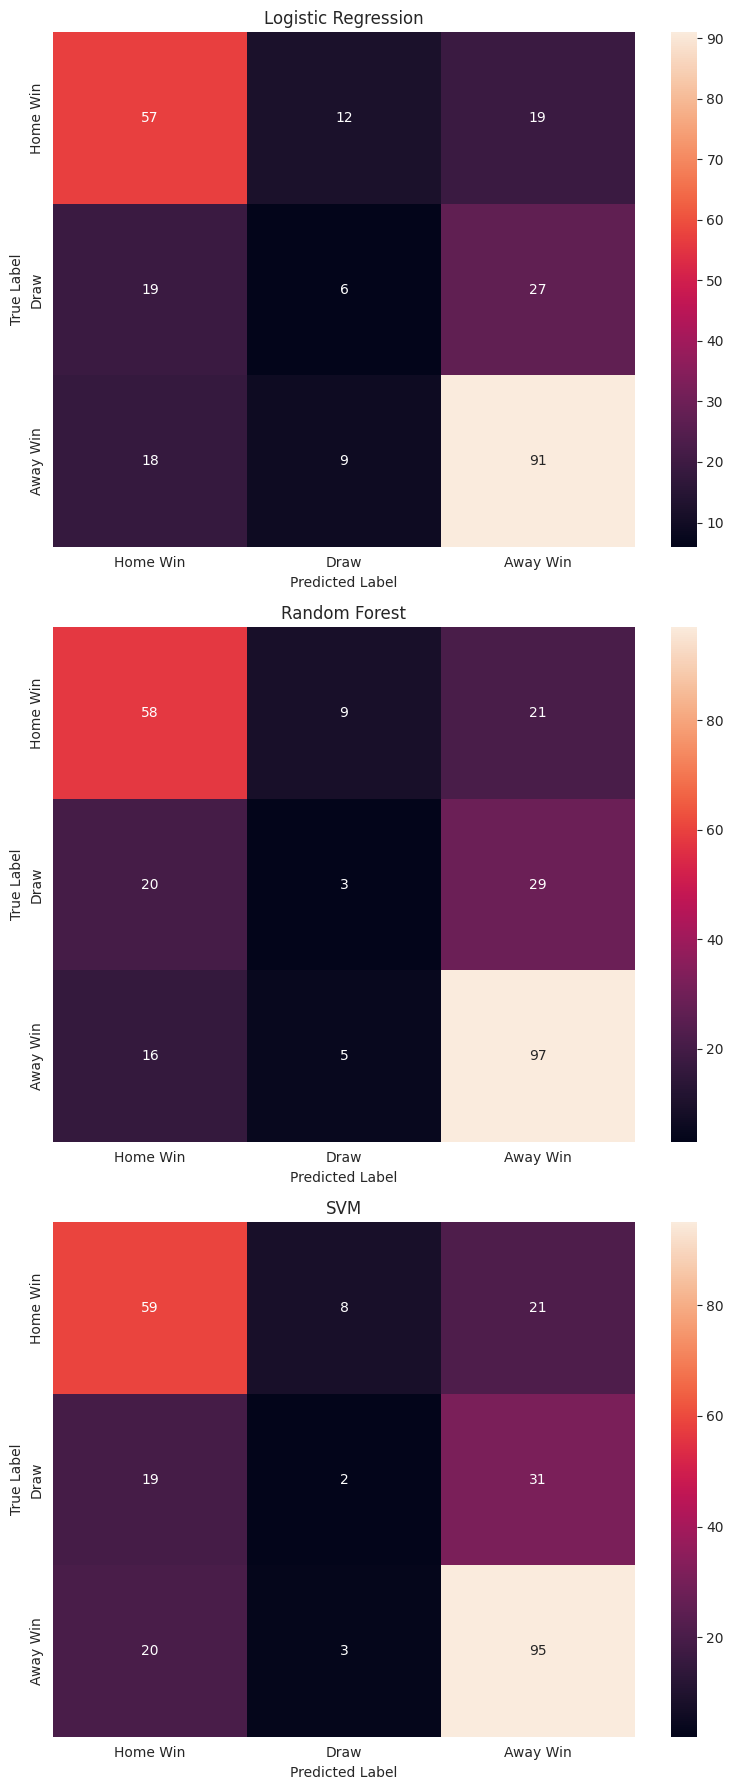

In [21]:
# Visualisation of model performance metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(metrics_names))

for i, (model_name, model_metrics) in enumerate(metrics.items()):
    scores = [model_metrics[metric] for metric in metrics_names]
    ax.bar(index + i*bar_width, scores, bar_width, label=model_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(index + bar_width * (len(pipelines) / 2 - 0.5))
ax.set_xticklabels(metrics_names)
ax.legend()
plt.show()

# Define class names
class_names = ['Home Win', 'Draw', 'Away Win']

# Generate and visualise confusion matrices for each model
fig, axes = plt.subplots(len(pipelines), 1, figsize=(8, 6 * len(pipelines)))

# Iterate over pipelines and axes
for ax, (model_name, pipeline) in zip(axes, pipelines.items()):
    # Generate predictions and confusion matrix
    predictions = pipeline.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)

    # Visualise the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    # Print confusion matrix results
    print(f"Confusion Matrix for {model_name}:")
    print(conf_matrix)

plt.tight_layout()
plt.show()


Feature Importances (ordered):
HomeTeamShotAccuracy: 0.08773671947919612
AwayTeamShotAccuracy: 0.0741329605571704
HomeTeamShotsOnTarget: 0.0736006891829844
AwayTeamShotsOnTarget: 0.06624145279672705
AwayTeamShots: 0.055506519788342305
HomeTeamShots: 0.05495371486292123
HomeTeamDefensiveStrength: 0.04762044009186023
AwayTeamDefensiveStrength: 0.046409759970218935
AwayTeamCorners: 0.04449422127920411
AwayTeamFouls: 0.044099114972123064
HomeTeamFouls: 0.04382224371211922
HomeTeamCorners: 0.04367952415191948
AwayTeamYellowCards: 0.03089333551207141
HomeTeamYellowCards: 0.030740827200320776
HomeTeamRedCards: 0.006510728121599767
AwayTeamRedCards: 0.00618535701459494
HomeTeam: 0.00589013478806468
AwayTeam: 0.004455393685653059


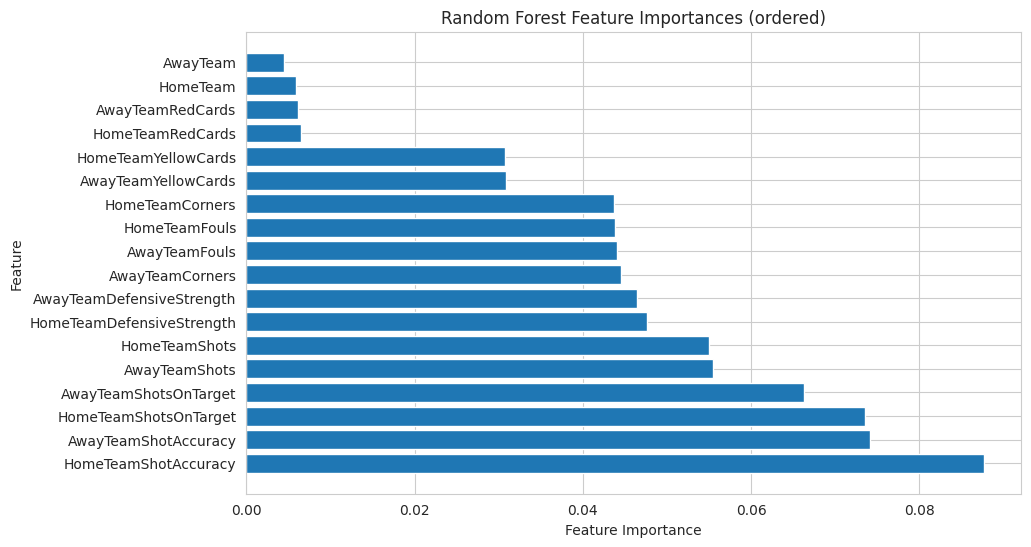

In [22]:
# Extract feature importances
feature_importances = pipelines['Random Forest']['model'].feature_importances_

# Create a list of tuples containing feature names and their importances
feature_importance_list = list(zip(selected_features, feature_importances))

# Sort the list by feature importances in descending order
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

# Print feature importances
print("Feature Importances (ordered):")
for feature_name, importance in feature_importance_list:
    print(f"{feature_name}: {importance}")

# Plotting the feature importance graph
plt.figure(figsize=(10, 6))
plt.barh([x[0] for x in feature_importance_list], [x[1] for x in feature_importance_list])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances (ordered)')
plt.show()


# Simulating Seasons

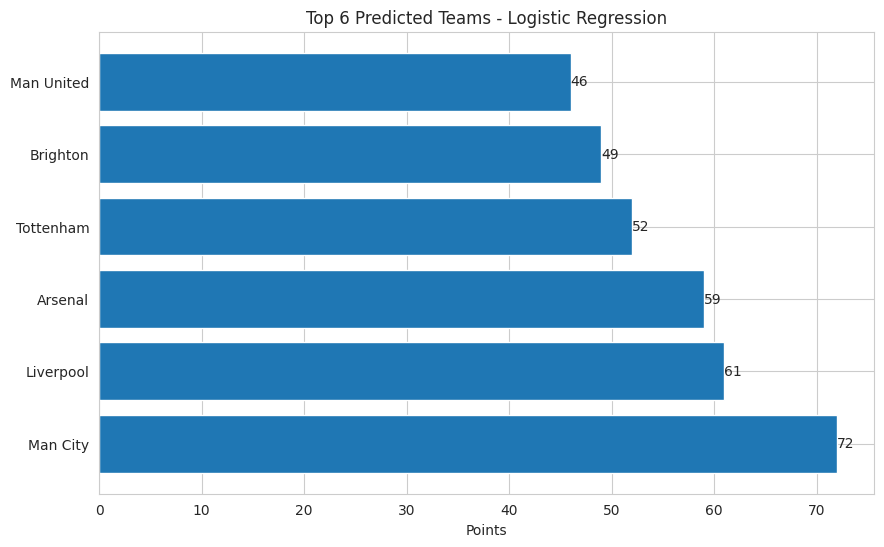

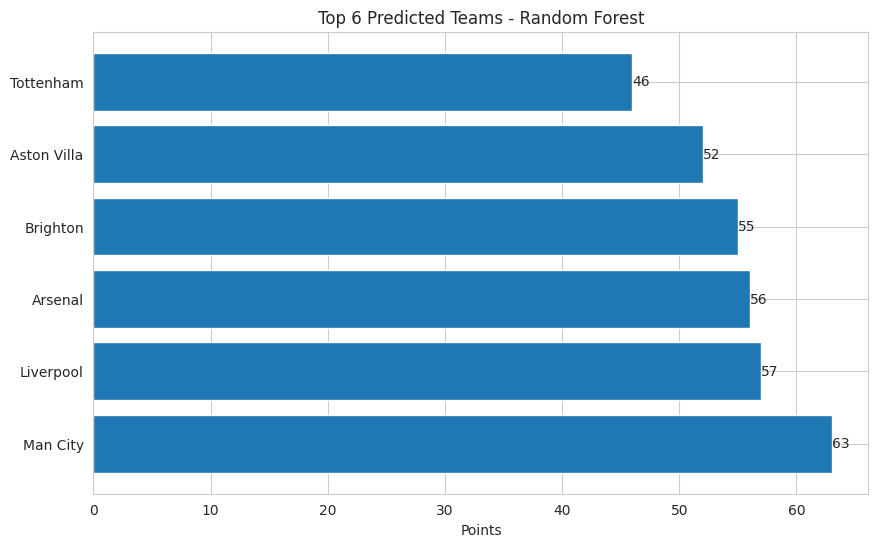

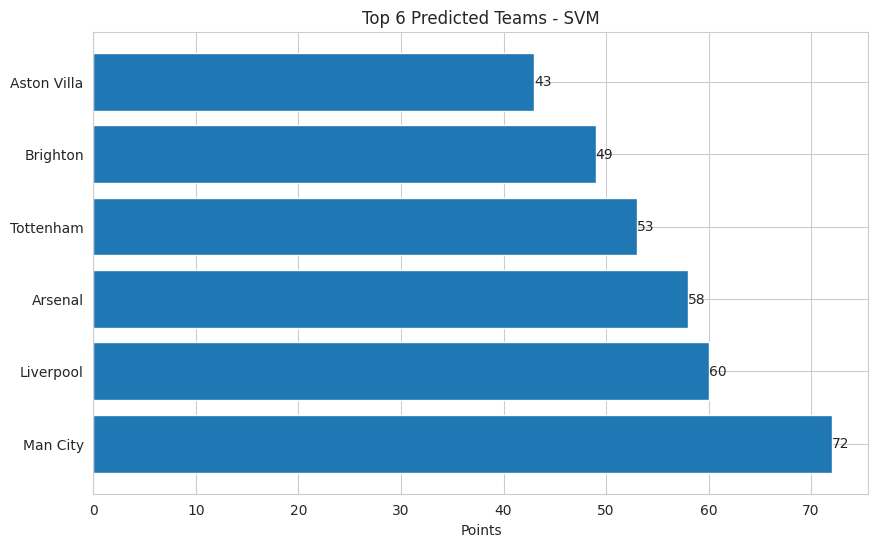

In [23]:
# Initial empty dictionary for team mapping
all_teams = np.unique(df[['HomeTeam', 'AwayTeam']])
team_mapping = {team: i for i, team in enumerate(all_teams)}

# Simulate season standings for each model using the adjusted function
season_simulations = {}
for model_name, pipeline in pipelines.items():
    season_simulations[model_name] = simulate_season(X_test, pipeline, team_mapping)

# Plotting the top 6 teams for each model separately
for model_name, standings in season_simulations.items():
    # Convert standings dictionary to a list of tuples (team, points), ensuring to use the team names
    standings_list = []
    for team_index, points in standings.items():
        team_name = list(team_mapping.keys())[list(team_mapping.values()).index(team_index)]
        standings_list.append((team_name, points))

    # Sort the list of tuples by points in descending order
    standings_list.sort(key=lambda team_points: team_points[1], reverse=True)
    # Select the top 6 teams
    top_6_standings = standings_list[:6]
    teams, points = zip(*top_6_standings)
    plt.figure(figsize=(10, 6))
    bars = plt.barh(teams, points)
    for bar, point in zip(bars, points):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(point), ha='left', va='center')

    plt.title(f"Top 6 Predicted Teams - {model_name}")
    plt.xlabel('Points')
    plt.show()


# Optimising Random Forest

## Hyperparameter Tuning

In [30]:
# Hyperparameter Tuning

# parameter grid
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create gridSearchcv object
grid_search = GridSearchCV(pipelines['Random Forest'], param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Use the best estimator for further predictions or analysis
best_rf_model = grid_search.best_estimator_

Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best score: 0.6026315789473684


## Evaluation

### Classification Reports

In [31]:
# Evaluate the model on the test data
predictions = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

# Print the evaluation metrics for model
print(f'Results for the Best Random Forest Model:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}\n')


Results for the Best Random Forest Model:
Accuracy: 0.6318
Precision: 0.5710
Recall: 0.6318
F1-Score: 0.5754



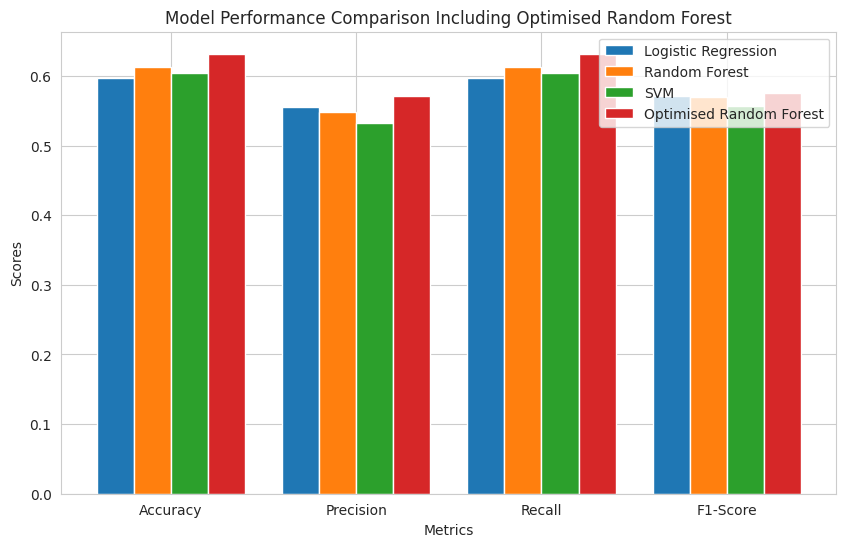

In [32]:
# Evaluate the best Random Forest model on the test data and update the metrics dictionary
best_rf_predictions = best_rf_model.predict(X_test)
best_rf_accuracy = accuracy_score(y_test, best_rf_predictions)
best_rf_report = classification_report(y_test, best_rf_predictions, output_dict=True)
best_rf_precision = best_rf_report['weighted avg']['precision']
best_rf_recall = best_rf_report['weighted avg']['recall']
best_rf_f1 = best_rf_report['weighted avg']['f1-score']

# Add the metrics of the optimised Random Forest model to the metrics dictionary
metrics['Optimised Random Forest'] = {
    'Accuracy': best_rf_accuracy,
    'Precision': best_rf_precision,
    'Recall': best_rf_recall,
    'F1-Score': best_rf_f1
}

# Visualisation of model performance metrics including the optimised Random Forest
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(metrics_names))

for i, (model_name, model_metrics) in enumerate(metrics.items()):
    scores = [model_metrics[metric] for metric in metrics_names]
    ax.bar(index + i*bar_width, scores, bar_width, label=model_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison Including Optimised Random Forest')
ax.set_xticks(index + bar_width * (len(metrics) / 2 - 0.5))
ax.set_xticklabels(metrics_names)
ax.legend()
plt.show()


### Confusion Matrix

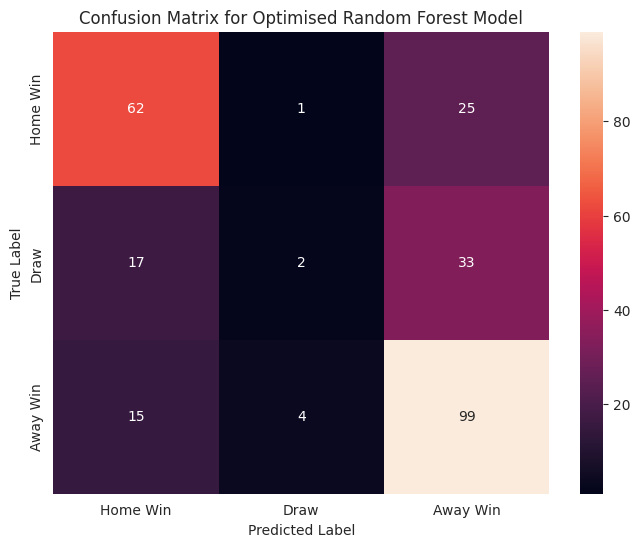

Confusion Matrix for Optimised Random Forest Model:
[[62  1 25]
 [17  2 33]
 [15  4 99]]


In [33]:
# Generate predictions for the test set using the optimised Random Forest model
optimised_rf_predictions = best_rf_model.predict(X_test)

# Calculate the confusion matrix
optimised_rf_conf_matrix = confusion_matrix(y_test, optimised_rf_predictions)

# Visualise the confusion matrix using seaborn heatmap for consistency
plt.figure(figsize=(8, 6))
sns.heatmap(optimised_rf_conf_matrix, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Optimised Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print confusion matrix results for the optimised Random Forest model
print("Confusion Matrix for Optimised Random Forest Model:")
print(optimised_rf_conf_matrix)


## Simulating the Season using the optimised model

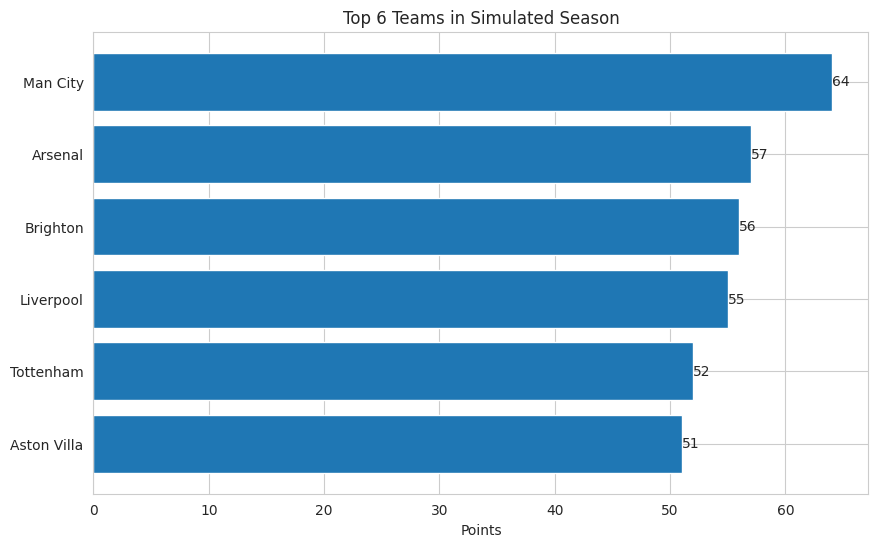

In [37]:
season_points = simulate_season(X_test, best_rf_model, team_mapping)

# Convert the team indices in the season_points dictionary back to team names
season_points_with_names = {list(team_mapping.keys())[list(team_mapping.values()).index(team_index)]: points for team_index, points in season_points.items()}

# Reverse map indices to team names
season_points_with_names = {index_to_name[team_index]: points for team_index, points in season_points.items()}
# Create dictionary of team names and points
sorted_teams_with_names = sorted(season_points_with_names.items(), key=lambda x: x[1], reverse=True)

top_teams = sorted_teams_with_names[:6]  # Top 6 teams
teams, points = zip(*top_teams) # This unpacks the top_6_standings tuples into two lists
plt.figure(figsize=(10, 6))
bars = plt.barh(teams, points)

# Show the total points for each of the top 6 teams
for bar, point in zip(bars, points):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, str(point), ha='left', va='center')

plt.xlabel('Points')
plt.title('Top 6 Teams in Simulated Season')
plt.gca().invert_yaxis()
plt.show()

